## 0. Imports

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys,os
import argparse
from tqdm import tqdm

#CAFPYANA working directory
CAFPYANA_WD = '/exp/sbnd/app/users/brindenc/develop/cafpyana'
os.environ['CAFPYANA_WD'] = CAFPYANA_WD

cafpyana_wd = os.environ.get('CAFPYANA_WD')
if cafpyana_wd and cafpyana_wd not in sys.path:
    sys.path.insert(0, cafpyana_wd)
    sys.path.insert(0, cafpyana_wd + '/pyanalib')

#My imports 
SBNDANA_DIR = '/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd'
sys.path.insert(0,SBNDANA_DIR)
sys.path.insert(0,f'{SBNDANA_DIR.replace("/numuincl/sbnd","/numuincl")}')
plt.style.use(f'{SBNDANA_DIR}/plotlibrary/numu2025.mplstyle')

from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.interaction import CAFInteraction
from sbnd.cafclasses.nu import NU
from sbnd.constants import *
from sbnd.numu.numu_constants import *
from sbnd.detector.definitions import * # >= v2.2

%load_ext autoreload
%autoreload 2

## 1. Constants

In [2]:
DATA_DIR = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both'
PLOT_DIR = f'{DATA_DIR}/plots'
#parser = argparse.ArgumentParser()
# parser.add_argument('--fname','-f', type=str, required=True, help='name of the file to process (directory not included, its in the DATA_DIR in the script)')
# args = parser.parse_args()
# FNAME = args.fname
MC_FNAME = 'mc_full.df'
OFFBEAM_FNAME = 'data_offbeam.df'
DATA_FNAME = 'data_dev.df'

from naming import *


print(f'MC file: {DATA_DIR}/{MC_FNAME}')
print(f'Offbeam file: {DATA_DIR}/{OFFBEAM_FNAME}')
print(f'Data file: {DATA_DIR}/{DATA_FNAME}')

MC file: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/mc_full.df
Offbeam file: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/data_offbeam.df
Data file: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/data_dev.df


In [3]:
# Get keys for h5 files
import h5py
mc_pand_keys = []
offbeam_pand_keys = []
data_pand_keys = []
mc_inter_keys = []
offbeam_inter_keys = []
data_inter_keys = []
mcnu_keys = []
hdr_keys = []
offbeam_hdr_keys = []
data_hdr_keys = []
# Check the keys in the H5 Files
for fname in [MC_FNAME,OFFBEAM_FNAME,DATA_FNAME]:
  print(f'File: {DATA_DIR}/{fname}')
  with h5py.File(f'{DATA_DIR}/{fname}', 'r') as f:
    # Store all keys at the root level
    for key in f.keys():
      if 'pand' in key:
        if fname == MC_FNAME:
          mc_pand_keys.append(key)
        elif fname == OFFBEAM_FNAME:
          offbeam_pand_keys.append(key)
        elif fname == DATA_FNAME:
          data_pand_keys.append(key)
      elif 'evt' in key and 'pand' not in key:
        if fname == MC_FNAME:
          mc_inter_keys.append(key)
        elif fname == OFFBEAM_FNAME:
          offbeam_inter_keys.append(key)
        elif fname == DATA_FNAME:
          data_inter_keys.append(key)
      elif 'mcnu' in key:
        if fname == MC_FNAME:
          mcnu_keys.append(key)
      elif 'hdr' in key:
        if fname == MC_FNAME:
          hdr_keys.append(key)
        elif fname == OFFBEAM_FNAME:
          offbeam_hdr_keys.append(key)
        elif fname == DATA_FNAME:
          data_hdr_keys.append(key)
print(mc_pand_keys,offbeam_pand_keys,mc_inter_keys,offbeam_inter_keys,mcnu_keys,hdr_keys)

File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/mc_full.df
File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/data_offbeam.df
File: /exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/data_dev.df
['evt_pand_0', 'evt_pand_1'] ['evt_pand_0'] ['evt_0', 'evt_1'] ['evt_0'] ['mcnu_0', 'mcnu_1'] ['hdr_0', 'hdr_1']


In [4]:
LIVETIME_DATA = 9.51e5 # From medulla
POT_MC = 0
for key in hdr_keys:
  POT_MC += pd.read_hdf(f'{DATA_DIR}/{MC_FNAME}',key=key).pot.sum()
LIVETIME_DATAOFFBEAM = 0
for key in offbeam_hdr_keys:
  LIVETIME_DATAOFFBEAM += pd.read_hdf(f'{DATA_DIR}/{OFFBEAM_FNAME}',key=key).noffbeambnb.sum()
POT_DATA = 0
#LIVETIME_DATA = 0
for key in data_hdr_keys:
  _hdr_df = pd.read_hdf(f'{DATA_DIR}/{DATA_FNAME}',key=key)
  POT_DATA += _hdr_df.pot.sum()
  #LIVETIME_DATA += _hdr_df.noffbeambnb.sum()

#Get POT label
pot_mag = int(np.floor(np.log10(POT_DATA)))
pot_base = POT_DATA/10**pot_mag
POT_LABEL = f'{pot_base:.2f} x 10$^{{{pot_mag}}}$ POT'
print(f'data POT: {POT_LABEL}, mc POT: {POT_MC:.2e}, offbeam livetime: {LIVETIME_DATAOFFBEAM:.2e}, data livetime: {LIVETIME_DATA:.2e}')

data POT: 4.58 x 10$^{18}$ POT, mc POT: 1.42e+19, offbeam livetime: 1.21e+06, data livetime: 9.51e+05


data POT: 4.58 x 10$^{18}$ POT, mc POT: 1.42e+19, offbeam livetime: 1.17e+06, data livetime: 9.51e+05

## 2. Post process (optional)

### 2.0 MCnu

In [39]:
df_lengths = []
for i,key in tqdm(enumerate(mcnu_keys),total=len(mcnu_keys),desc='Loading MCnu'):
  if i == 0:
    mcnu = NU.load(f'{DATA_DIR}/{MC_FNAME}',key=key)
    df_lengths.append(len(mcnu.data))
  else:
    _mcnu = NU.load(f'{DATA_DIR}/{MC_FNAME}',key=key)
    df_lengths.append(len(_mcnu.data))
    mcnu.combine(_mcnu)
print(np.array(df_lengths).sum(),len(mcnu.data))

Loading MCnu:   0%|          | 0/2 [00:00<?, ?it/s]

Loading MCnu: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]

300672 300672


In [40]:
# Post process
mcnu.scale_to_pot(POT_DATA,sample_pot=POT_MC)

mcnu.add_fv()
mcnu.add_av()

mcnu.cut_muon(cut=APPLY_CUTS,min_ke=0.1)
mcnu.cut_fv(cut=APPLY_CUTS)
mcnu.cut_cosmic(cut=APPLY_CUTS)
mcnu.cut_cont(cut=APPLY_CUTS)

--scaling to POT: 1.42e+19 -> 4.58e+18


/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/cafclasses/nu.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False  True ... False  True False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.data.loc[:,cols[0]] = involume(self.data.position,volume=FV)
/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/cafclasses/nu.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False  True ... False  True False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.data.loc[:,cols[0]] = involume(self.data.position,volume=AV)


added key: cut.muon
added key: cut.fv
added key: cut.cosmic
added key: cut.cont


In [41]:
with open('mcnu_keys.txt','w') as f:
  for k in mcnu.data.keys():
    f.write(f'{k}\n')

In [42]:
# slc_copy = slc.copy()
# slc_copy.data.dropna(subset=slc_copy.get_key('truth.ind'),inplace=True)
# ind_keys = ['__ntuple','entry','ind'] #ind keys to use after reindexing
# ind_cols = [slc_copy.get_key(k)[0] for k in ind_keys]
# slc_copy.data.index = slc_copy.data.index.droplevel(-1)
# slc_copy.data = slc_copy.data.set_index(slc_copy.data.truth.ind,append=True)
# keys = [slc_copy.get_key(n)[0] for n in slc_copy.data.index.names]
# slc_copy.data.index.names = [None] * len(slc_copy.data.index.names) #Drop names of indices

### 2.1. Slice (Pandora)

In [80]:
slc_data = None

In [81]:
df_lengths = []
for i,key in tqdm(enumerate(mc_pand_keys),total=len(mc_pand_keys),desc='Loading Pandora'):
  if i == 0:
    slc = CAFSlice.load(f'{DATA_DIR}/{MC_FNAME}', key=key, pot=POT_MC)
    slc.scale_to_pot(POT_DATA,sample_pot=POT_MC)
    df_lengths.append(len(slc.data))
  else:
    _slc = CAFSlice.load(f'{DATA_DIR}/{MC_FNAME}', key=key, pot=POT_MC)
    _slc.scale_to_pot(POT_DATA,sample_pot=POT_MC)
    df_lengths.append(len(_slc.data))
    slc.combine(_slc)
print(np.array(df_lengths).sum(),len(slc.data))

Loading Pandora:   0%|          | 0/2 [00:00<?, ?it/s]

Loading Pandora:  50%|█████     | 1/2 [00:05<00:05,  5.85s/it]

--scaling to POT: 1.42e+19 -> 4.58e+18
--scaling to POT: 1.42e+19 -> 4.58e+18


Loading Pandora: 100%|██████████| 2/2 [00:12<00:00,  6.36s/it]

1498960 1498960


In [82]:
#Add offbeam data
offbeam_df_lengths = []
for i,key in tqdm(enumerate(offbeam_pand_keys),total=len(offbeam_pand_keys),desc='Loading Pandora'):
  _slc_intime = CAFSlice.load(f'{DATA_DIR}/{OFFBEAM_FNAME}', key=key, livetime=LIVETIME_DATAOFFBEAM)
  _slc_intime.scale_to_livetime(LIVETIME_DATA,sample_livetime=LIVETIME_DATAOFFBEAM)
  df_lengths.append(len(_slc_intime.data))
  slc.combine(_slc_intime,duplicate_ok=True)
print(np.array(offbeam_df_lengths+df_lengths).sum(),len(slc.data))

Loading Pandora:   0%|          | 0/1 [00:00<?, ?it/s]

--scaling to livetime: 1.21e+06 -> 9.51e+05


Loading Pandora: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]

1724046 1724046


In [83]:
#Set pandora containment and event type
mcnu = slc.set_mcnu_containment(mcnu)
mcnu.add_event_type('pandora')

In [84]:
slc.clean(dummy_vals=[-9999,-999,999,9999,-5])

slc.add_has_muon()
slc.add_in_av()
slc.add_in_fv()
slc.cut_cosmic(cut=APPLY_CUTS,fmatch_score=320,nu_score=0.5,use_opt0=True,use_isclearcosmic=True)
slc.cut_fv(cut=APPLY_CUTS)
slc.cut_muon(cut=APPLY_CUTS,min_ke=0.1)
slc.cut_is_cont(cut=APPLY_CUTS)

#I know there is an offbeam sample combined. There is a nan check in the function that assigns these as cosmics
slc.add_event_type()

Number of clear cosmic: 1288275
Cutting is clear cosmic
Cutting opt0 score: 320
Cutting nu score: 0.5
added key: cut.cosmic
added key: cut.truth.cosmic
added key: cut.fv
added key: cut.truth.fv
added key: cut.muon
added key: cut.truth.muon
added key: cut.cont
added key: cut.truth.cont


In [85]:
with open('slc_keys.txt','w') as f:
  for k in slc.data.keys():
    f.write(f'{k}\n')

In [ ]:
pur,eff,f1 = slc.get_pur_eff_f1(mcnu,PAND_CUTS_CONT,categories=[0,1])
pur,eff,f1

(array([0.0349515 , 0.50440915, 0.76173842, 0.90423705, 0.90998732]),
 array([1.        , 0.73257427, 0.72476192, 0.62831455, 0.31296926]),
 array([1.        , 0.59744886, 0.74279028, 0.74143708, 0.46575335]))

In [87]:
pur,eff,f1 = slc.get_pur_eff_f1(mcnu,PAND_CUTS_CONT,categories=[0])
pur,eff,f1

(array([0.01539228, 0.2320191 , 0.3515168 , 0.48101912, 0.90425882]),
 array([1.        , 0.78837695, 0.78242325, 0.78242325, 0.72701826]),
 array([1.        , 0.35852454, 0.48509604, 0.59577002, 0.80600982]))

### 2.2. Interaction (SPINE)

In [116]:
inter_data = None

In [117]:
df_lengths = []
for i,key in tqdm(enumerate(mc_inter_keys),total=len(mc_inter_keys),desc='Loading SPINE'):
  if i == 0:
    inter = CAFInteraction.load(f'{DATA_DIR}/{MC_FNAME}', key=key, pot=POT_MC)
    inter.scale_to_pot(POT_DATA,sample_pot=POT_MC)
    df_lengths.append(len(inter.data))
  else:
    _inter = CAFInteraction.load(f'{DATA_DIR}/{MC_FNAME}', key=key, pot=POT_MC)
    _inter.scale_to_pot(POT_DATA,sample_pot=POT_MC)
    df_lengths.append(len(_inter.data))
    inter.combine(_inter)
print(np.array(df_lengths).sum(),len(inter.data))

Loading SPINE:  50%|█████     | 1/2 [00:23<00:23, 23.71s/it]

--scaling to POT: 1.42e+19 -> 4.58e+18
--scaling to POT: 1.42e+19 -> 4.58e+18


Loading SPINE: 100%|██████████| 2/2 [00:52<00:00, 26.30s/it]

2058842 2058842


In [118]:
offbeam_df_lengths = []
for i,key in tqdm(enumerate(offbeam_inter_keys),total=len(offbeam_inter_keys),desc='Loading SPINE'):
  _inter = CAFInteraction.load(f'{DATA_DIR}/{OFFBEAM_FNAME}', key=key, pot=POT_DATA)
  _inter.scale_to_livetime(LIVETIME_DATA,sample_livetime=LIVETIME_DATAOFFBEAM)
  offbeam_df_lengths.append(len(_inter.data))
  inter.combine(_inter,duplicate_ok=True)
print(np.array(offbeam_df_lengths+df_lengths).sum(),len(inter.data))

Loading SPINE:   0%|          | 0/1 [00:00<?, ?it/s]

--scaling to livetime: 1.21e+06 -> 9.51e+05


Loading SPINE: 100%|██████████| 1/1 [00:19<00:00, 19.81s/it]

2339120 2339120


In [120]:
from pyanalib import pandas_helpers
mcnu_copy = mcnu.copy()
algo = 'spine'
pgrp_df = inter.data.copy()
pgrp_df.dropna(subset=inter.get_key('truth.ind'),inplace=True) # Get rid of any rows without truth info
pgrp_df.index = pgrp_df.index.droplevel(-1) #Drop slice index
pgrp_df = pgrp_df.set_index(pgrp_df.truth.ind,append=True) #Use nu index
pgrp_df.index.names = [None] * len(pgrp_df.index.names) #Drop names of indices

#Drop any indices that are not in the mcnu_copy index
pgrp_df = pgrp_df[pgrp_df.index.isin(mcnu_copy.data.index)]
#Drop duplicated pgrp_df indices
pgrp_df = pgrp_df.loc[~pgrp_df.index.duplicated(keep='first')]

#Add to mcnu
keys = [f'mu.is_{algo}_contained']
mcnu_copy.add_key(keys,fill=False) #Fill to false by default
cols = pandas_helpers.getcolumns(keys,depth=mcnu_copy.key_length())
if algo == 'pandora':
    is_contained = (pgrp_df.mu.pfp.trk.truth.p.contained == 1) | (pgrp_df.mu.pfp.trk.truth.p.contained == True)
elif algo == 'spine':
    is_contained = (pgrp_df.mu.tpart.is_contained == 1) | (pgrp_df.mu.tpart.is_contained == True)
mcnu_copy.data.loc[pgrp_df.index,cols] = is_contained

In [121]:
#Set pandora containment and event type
mcnu = inter.set_mcnu_containment(mcnu)
mcnu.add_event_type('spine')

In [ ]:
inter.clean(dummy_vals=[-9999,-999,999,9999,-5,np.inf,-np.inf])
inter.add_in_fv()
inter.add_in_av()

inter.cut_cosmic(cut=APPLY_CUTS)
inter.cut_fv(cut=APPLY_CUTS)
inter.cut_muon(cut=APPLY_CUTS,min_ke=0.1)
inter.cut_is_cont(cut=APPLY_CUTS)
inter.cut_start_dedx(cut=APPLY_CUTS,dedx=4.17)
inter.cut_cosmic_score(cut=APPLY_CUTS,score=102.35)

inter.add_event_type()

In [ ]:
inter.data.truth.event_type.value_counts()

event_type
6    2115088
3      67683
1      55791
5      40419
2      31206
0      27864
4       1069
Name: count, dtype: int64

In [ ]:
slc.data.truth.event_type.value_counts()

event_type
6    1568383
3      53798
1      33721
0      26537
2      22804
5      18143
4        660
Name: count, dtype: int64

In [ ]:
with open('inter_keys.txt','w') as f:
  for k in inter.data.keys():
    f.write(f'{k}\n')

In [ ]:
pur,eff,f1 = inter.get_pur_eff_f1(mcnu,SPINE_CUTS,categories=[0,1])
pur,eff,f1

(array([0.03576345, 0.30778724, 0.55576452, 0.80786135, 0.89638324,
        0.93691962]),
 array([1.        , 0.94402099, 0.91438727, 0.83588359, 0.80227718,
        0.79454086]),
 array([1.        , 0.46422065, 0.69133542, 0.82163361, 0.84672346,
        0.85987631]))

In [ ]:
pur,eff,f1 = inter.get_pur_eff_f1(mcnu,SPINE_CUTS_CONT,categories=[0])
pur,eff,f1

(array([0.01191217, 0.13411829, 0.24767362, 0.38753468, 0.93682501]),
 array([1.        , 0.94759592, 0.93880525, 0.91495872, 0.91170471]),
 array([1.        , 0.23497878, 0.39194511, 0.5444607 , 0.92409418]))

In [ ]:
1/(len(inter.data)/len(slc.data))

0.7821187193849078

## 3. Just load the data

In [5]:
MC_FNAME = 'mc_full.df'
slc = CAFSlice.load(f"{DATA_DIR}/{MC_FNAME.replace('.df','_postprocess.df')}",key='pandora')
inter = CAFInteraction.load(f"{DATA_DIR}/{MC_FNAME.replace('.df','_postprocess.df')}",key='spine')
mcnu = NU.load(f"{DATA_DIR}/{MC_FNAME.replace('.df','_postprocess.df')}",key='mcnu')
#PLOT_DIR += '_small'

slc_data = CAFSlice.load(f"{DATA_DIR}/{DATA_FNAME.replace('.df','_postprocess.df')}",key='pandora')
inter_data = CAFInteraction.load(f"{DATA_DIR}/{DATA_FNAME.replace('.df','_postprocess.df')}",key='spine')

### 3.1 Rescale to MC POT

In [6]:
old_pot_data = POT_DATA
POT_DATA = 3.48e20 # Run 1 stats
POT_LABEL = '3.48 x 10$^{20}$ POT'

# Rescale to POT_DATA
slc.scale_to_pot(POT_DATA,sample_pot=old_pot_data)
inter.scale_to_pot(POT_DATA,sample_pot=old_pot_data)
mcnu.scale_to_pot(POT_DATA,sample_pot=old_pot_data)

--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20
--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20
--scaling to POT (7.60e+01): 4.58e+18 -> 3.48e+20


In [7]:
POT_DATA/POT_MC

24.4242252580815

24.4242252580815

## 4. Make plots as function of cut

In [8]:
# Break data into lists of objects
slcs = []
inters = []

#Get event type col
slc_event_type_col = slc.get_key('truth.event_type')
inter_event_type_col = inter.get_key('truth.event_type')

# Group data by event type once
slc_groups = slc.data.groupby(slc_event_type_col)
inter_groups = inter.data.groupby(inter_event_type_col)

# Create objects only for groups that exist
for key, val in EVENT_TYPE_LIST.items():
    if key in slc_groups.groups:
        slcs.append(CAFSlice(slc_groups.get_group(key)))
    
    if key in inter_groups.groups:
        inters.append(CAFInteraction(inter_groups.get_group(key)))

/tmp/ipykernel_1841/4089239904.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  slcs.append(CAFSlice(slc_groups.get_group(key)))
/tmp/ipykernel_1841/4089239904.py:19: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  inters.append(CAFInteraction(inter_groups.get_group(key)))


In [9]:
#Get label info
labels = []
names = []
colors = []

for key,item in EVENT_TYPE_LIST.items():
    if key == -1: #no unknown for now
        continue
    labels.append(item[0])
    names.append(item[1])
    colors.append(item[2])

slc_weights = [s.data.genweight for s in slcs]
inter_weights = [i.data.genweight for i in inters]

#Assert no nans in weights
assert [any(np.isnan(sw)) for sw in slc_weights].count(True) == 0
assert [any(np.isnan(iw)) for iw in inter_weights].count(True) == 0


### 4.1 Spectra + Pur/eff tables

In [17]:
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters
def create_hist(series,labels,dens,data_series=None,scale_data=False,cut_desc='',xlabel='',label='',colors=None,weights=None,bins=20,cut='',savename='hist'
                ,plot_dir=None,stat_label='',data_events=None,dens_norm=15,**kwargs):
    """
    Create a histogram from a list of series each corresponding
    to a different true event type. Data series is optional.

    Parameters
    ----------
    series : list of pd.Series
        List of series, each corresponding to a different true event type.
    labels : list of str
        List of labels, each corresponding to a different true event type.
    dens : bool
        If True, the histogram is normalized to a density.
    data_series : pd.Series, optional
        Series which contains data.
    scale_data : bool, optional
        If True, the data series is scaled to the total number of events.
    cut_desc : str, optional
        Description of the cut.
    label : str, optional
        Label of the plot.
    xlabel : str, optional
        Label of the x-axis.
    colors : list of str, optional
        List of colors, each corresponding to a different true event type.
    weights : list of float, optional
        List of weights, each corresponding to a different true event type.
    bins : int, optional
        Number of bins in the histogram.
    cut : str, optional
        Cut applied to the data.
    savename : str, optional
        Name of the file to save the histogram.
    stat_label : str, optional
        Label of the statistic.
    data_events : int, optional
        Number of data events.
    dens_norm : float, optional
        Normalization factor for the density.
    **kwargs : dict
        Additional keyword arguments.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure of the histogram.
    ax : matplotlib.axes.Axes
        Axes of the histogram.
    counts : np.ndarray
        Counts of the histogram.
    """
    
    if len(series) == 0:
        print(f'No events in series'+'\n'+f'xlabel: {xlabel}'+'\n'+f'cut: {cut}'+'\n'+f'savename: {savename}')
        return None,None,None
    if dens:
        histtype = 'step'
        alpha = 0.9
    else:
        histtype = 'barstacked'
        alpha = 0.8
    fig,ax,counts = makeplot.plot_hist(series,labels,xlabel=xlabel,colors=colors,weights=weights,return_counts=True
                   ,histtype=histtype,lw=2,bins=bins,alpha=alpha,density=dens,**kwargs)
    if data_series is not None:
        #Group data by binning, get mean and std of data series
        bin_centers = (bins[:-1] + bins[1:]) / 2
        data_counts = data_series.groupby(pd.cut(data_series,bins=bins)).count()
        data_stds = np.sqrt(data_counts)
        if dens:
            data_counts = data_counts * (dens_norm/len(data_series))
            data_stds = data_stds * (dens_norm/len(data_series))
        if not dens and scale_data:
            data_counts = data_counts * (np.sum(counts)/len(data_series))
            data_stds = data_stds * (np.sum(counts)/len(data_series))
        if data_events is not None:
            ax.errorbar(bin_centers,data_counts,yerr=None,fmt='o',color='black',label=f'Data ({round(data_events):,})')
        else:
            ax.errorbar(bin_centers,data_counts,yerr=None,fmt='o',color='black',label=f'Data ({round(len(data_series)):,})')
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Candidates')
    y_lim = ax.get_ylim()
    if y_lim[1] > 1e6: #this means scientific notation kicks on, so we need to shift the label
      label_y_shift = 0.06
    else:
      label_y_shift = 0
    #Add labels
    plotters.add_label(ax,POT_LABEL,where='toprightoutside',color='black',alpha=1.,fontsize=12)
    plotters.add_label(ax,label,where=(0.01,1.07+label_y_shift) if '\n' not in label else (0.01,1.15+label_y_shift)
      ,color='gray',alpha=0.9,fontsize=10,horizontalalignment='left',verticalalignment='top')
    plotters.add_label(ax,stat_label,where='bottomrightoutside',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    #plotters.set_style(ax)
    if savename is not None:
        if plot_dir is None:
          raise ValueError('plot_dir is None')
        plotters.save_plot(f'{savename}',fig=fig,folder_name=plot_dir)
        plt.close('all')
    return fig,ax

In [11]:
def create_purity_efficiency_table(pur,eff,labels, ax, differential_eff=True,differential_pur=True):
    """
    Create a pretty table for purity data similar to the efficiency table format.
    
    Parameters
    ----------
    pur : list
        List of purities
    eff : list
        List of efficiencies
    labels : list
        List of labels
    ax : matplotlib.axes.Axes
        The axis to draw the table on
    differential_eff : bool
        If True, the efficiency is differential
    differential_pur : bool
        If True, the purity is differential
    """
    # Clear the axis for table display
    ax.axis('off')

    # Allow us to be lazy
    if (len(pur)-1 == len(labels)) and labels[0] != 'No cut':
      labels.insert(0,'No cut')
    elif (len(pur) == len(labels)) and labels[0] == 'No cut':
      pass
    else:
      raise ValueError(f'Purity and label lists are not the same length: {len(pur)} != {len(labels)}')

    if max(pur) <= 1:
      pur = [p*100 for p in pur]
    if max(eff) <= 1:
      eff = [e*100 for e in eff]
    # Create DataFrame
    results = pd.DataFrame({
        'Cut': labels,
        'Purity [%]': [round(p,2) for p in pur],
        'Efficiency [%]': [round(e,2) for e in eff]
    })

    if differential_eff:
      diff_eff = [100.]*len(eff)
      for i,_eff in enumerate(eff):
        if i == 0:
          continue
        diff_eff[i] = round(100-(eff[i-1]-_eff),2)
      diff_eff[0] = 'n/a'
      results['Differential\nEfficiency [%]'] = diff_eff
    if differential_pur:
        diff_pur = [100.]*len(pur)
        for i,_pur in enumerate(pur):
          if i == 0:
            continue
          diff_pur[i] = round(_pur-pur[i-1],2)
        diff_pur[0] = 'n/a'
        results['Differential\nPurity [%]'] = diff_pur
    
    # Create table data
    table_data = [results.columns.to_list()] + results.values.tolist()
    
    # Create the table
    table = ax.table(cellText=table_data, colLabels=None, loc='center', 
                    cellLoc='center', edges='T')
    x_scale,y_scale = 1.,2.5

    table.scale(x_scale, y_scale)
    table.auto_set_column_width(col=list(range(len(table_data[0]))))
    
    # Style the table edges
    for i in range(2, len(table_data)):
        if i == len(table_data) - 1:
            # Bottom row gets bottom edge
            for j in range(len(table_data[i])):
                table[i, j].visible_edges = 'B'
        else:
            # Other rows get no edges except for group separators
            for j in range(len(table_data[i])):
                table[i, j].visible_edges = 'open'
    
    # Auto-scale the table to fit
    def calc_bbox_yext(obj):
        figure = plt.gcf()
        bbox = obj.get_window_extent(renderer=figure.canvas.get_renderer())
        p0, p1 = figure.transFigure.inverted().transform(bbox)
        return p1[1] - p0[1]

    # while calc_bbox_yext(table) > 0.92:
    #     table.scale(1, 1/y_scale)
    #     y_scale -= 0.05
    #     table.scale(1, y_scale)
    
    if y_scale < 2.0:
        print(f'Warning: Table with title `{title}` is too large to fit on the figure (scale = {scale:.2f}). Consider extending the figure vertically.')

    return ax,table

#### 4.1.1. Pandora

In [12]:
pur, eff, f1 = slc.get_pur_eff_f1(mcnu, PAND_CUTS, categories=[0,1])

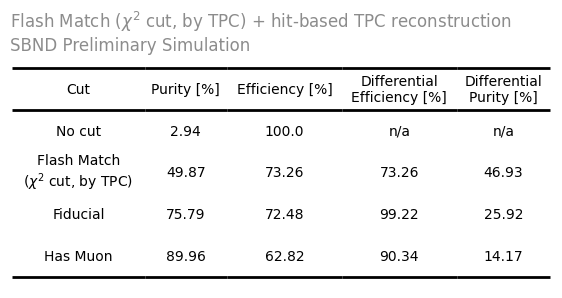

In [13]:
fig, ax = plt.subplots(figsize=(7, 3))
ax,table = create_purity_efficiency_table(pur, eff, PAND_CUT_LABELS, ax)
plotters.add_label(ax,PANDORA_QUALIFIER_PRELIM_LABEL,where=(0.0,1.03),color='gray',alpha=0.9,fontsize=12)
plotters.save_plot('pur_eff_table_uncont_pandora',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

In [14]:
pur, eff, f1 = slc.get_pur_eff_f1(mcnu, PAND_CUTS_CONT, categories=[0])
pur,eff

(array([0.01294101, 0.22939835, 0.34976141, 0.47855962, 0.90388935]),
 array([1.        , 0.78837695, 0.78242325, 0.78224552, 0.72701826]))

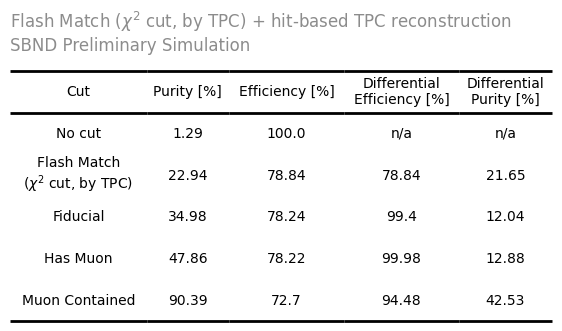

In [15]:
fig, ax = plt.subplots(figsize=(7, 3))
ax,table = create_purity_efficiency_table(pur, eff, PAND_CUT_LABELS_CONT, ax)
plotters.add_label(ax,PANDORA_QUALIFIER_PRELIM_LABEL,where=(0.0,1.13),color='gray',alpha=0.9,fontsize=12)
plotters.save_plot('pur_eff_table_cont_pandora',fig=fig,folder_name=f'{PLOT_DIR}/pandora')

In [24]:
m = np.isin(slc.data.truth.event_type,[1,0])
abs(slc.data[m].mu.pfp.trk.truth.p.pdg).value_counts(normalize=True)

pdg
1.300000e+01    0.950674
2.110000e+02    0.027983
2.212000e+03    0.021143
3.210000e+02    0.000180
1.000020e+09    0.000020
Name: proportion, dtype: float64

In [18]:
# Make spectra for pandora
_slcs = slcs 
_slc_weights = slc_weights
_slc_data = None #Set to slc_data if you want to plot data
data_counts = []

pur, eff, f1 = slc.get_pur_eff_f1(mcnu, PAND_CUTS_CONT, categories=[0,1])

# Initialize variables outside the loop
_data_events = None
cut_descriptions = []

# Pre-compute cut descriptions
for i, cut in enumerate(['precut'] + PAND_CUTS_CONT):
    cut_desc = f'{cut}:' + '\n' + f'Pur = {pur[i]:.2f}' + '\n' + f'Eff = {eff[i]:.2f}' + '\n' + f'F1 = {f1[i]:.2f}'
    cut_descriptions.append(cut_desc)

# Main loop - only copy data when we need to apply cuts
for i, cut in enumerate(['precut'] + PAND_CUTS_CONT):
    print('*' * 70)
    print(f'cut: {cut}')
    
    if cut != 'precut':
        # Only copy when we need to apply cuts
        if i == 1:  # First cut application
            _slcs = [s.copy() for s in slcs]
            _slc_weights = [w.copy() for w in slc_weights]
            if _slc_data is not None:
                _slc_data = slc_data.copy()
            else:
                _slc_data = None
        
        # Apply cuts in batch
        for s in _slcs:
            s.apply_cut(cut)
        
        if _slc_data is not None:
            _slc_data.apply_cut(cut)
            _data_events = len(_slc_data.data)
            data_counts.append(_data_events)
            print(f'len(_slc_data): {_data_events}')
        else:
            _data_events = None
    
    # Pre-compute data access
    total_events = np.sum([len(_s.data) for _s in _slcs])
    print(f'len(_slcs): {total_events}')
    
    # Muon information
    costheta = [s.data.mu.pfp.trk.costheta for s in _slcs]
    momentum = [s.data.mu.pfp.trk.P.p_muon for s in _slcs]
    length = [s.data.mu.pfp.trk.len for s in _slcs]

    # -start and end points
    start_x = [s.data.mu.pfp.trk.start.x for s in _slcs]
    start_y = [s.data.mu.pfp.trk.start.y for s in _slcs]
    start_z = [s.data.mu.pfp.trk.start.z for s in _slcs]
    end_x = [s.data.mu.pfp.trk.end.x for s in _slcs]
    end_y = [s.data.mu.pfp.trk.end.y for s in _slcs]
    end_z = [s.data.mu.pfp.trk.end.z for s in _slcs]

    # -direction
    direction_x = [s.data.mu.pfp.trk.dir.x for s in _slcs]
    direction_y = [s.data.mu.pfp.trk.dir.y for s in _slcs]
    direction_z = [s.data.mu.pfp.trk.dir.z for s in _slcs]

    # Interaction information
    opt0_score = [1/s.data.slc.opt0.score for s in _slcs]
    opt0_time = [s.data.slc.opt0.time for s in _slcs]

    # -interaction vertex
    interaction_x = [s.data.slc.vertex.x for s in _slcs]
    interaction_y = [s.data.slc.vertex.y for s in _slcs]
    interaction_z = [s.data.slc.vertex.z for s in _slcs]

    # Get weights
    _weights = [s.data.genweight for s in _slcs]

    # Get data
    if _slc_data is not None:
      # Muon information
      costheta_data = _slc_data.data.mu.pfp.trk.costheta
      momentum_data = _slc_data.data.mu.pfp.trk.P.p_muon
      length_data = _slc_data.data.mu.pfp.trk.len

      # -start and end points
      start_x_data = _slc_data.data.mu.pfp.trk.start.x
      start_y_data = _slc_data.data.mu.pfp.trk.start.y
      start_z_data = _slc_data.data.mu.pfp.trk.start.z
      end_x_data = _slc_data.data.mu.pfp.trk.end.x
      end_y_data = _slc_data.data.mu.pfp.trk.end.y
      end_z_data = _slc_data.data.mu.pfp.trk.end.z

      # -direction
      direction_x_data = _slc_data.data.mu.pfp.trk.dir.x
      direction_y_data = _slc_data.data.mu.pfp.trk.dir.y
      direction_z_data = _slc_data.data.mu.pfp.trk.dir.z

      # Interaction information
      opt0_score_data = 1/_slc_data.data.slc.opt0.score
      opt0_time_data = _slc_data.data.slc.opt0.time
      
      # -interaction vertex
      interaction_x_data = _slc_data.data.slc.vertex.x
      interaction_y_data = _slc_data.data.slc.vertex.y
      interaction_z_data = _slc_data.data.slc.vertex.z
      
    else: #Set all to None if no data
      costheta_data = None
      momentum_data = None
      length_data = None
      start_x_data = None
      start_y_data = None
      start_z_data = None
      end_x_data = None
      end_y_data = None
      end_z_data = None
      direction_x_data = None
      direction_y_data = None
      direction_z_data = None
      opt0_score_data = None
      opt0_time_data = None
      interaction_x_data = None
      interaction_y_data = None
      interaction_z_data = None

    # Use pre-computed cut description
    cut_desc = cut_descriptions[i]
    
    # Create plots for both density and counts
    for dens in [False, True]:
        plot_dir = f'{PLOT_DIR}/pandora/{cut}/{"dens" if dens else "counts"}'
        
        #Muon infomation
        # -Costheta
        fig, ax = create_hist(
            costheta, labels, dens,
            data_series=costheta_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\cos\theta_{\mu}$',
            label=PANDORA_QUALIFIER_PRELIM_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-1, 1.1, 0.1),
            cut=cut,
            savename='costhetamu',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Start z
        fig, ax = create_hist(
            start_z, labels, dens,
            data_series=start_z_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Start Z [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-50, 650, 5),
            cut=cut,
            savename='reco_start_z',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )
    #     break
    # break
        
        #-Momentum
        fig, ax = create_hist(
            momentum, labels, dens,
            data_series=momentum_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Momentum [GeV/c]',
            label=PANDORA_QUALIFIER_PRELIM_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(0, 2.6, 0.1),
            cut=cut,
            savename='pmu',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Length
        fig, ax = create_hist(
            length, labels, dens,
            data_series=length_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Length [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(0, 700, 5),
            cut=cut,
            savename='reco_length',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Start x
        fig, ax = create_hist(
            start_x, labels, dens,
            data_series=start_x_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Start X [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-250, 350, 5),
            cut=cut,
            savename='reco_start_x',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Start y
        fig, ax = create_hist(
            start_y, labels, dens,
            data_series=start_y_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Start Y [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-250, 350, 5),
            cut=cut,
            savename='reco_start_y',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )


        # -End x
        fig, ax = create_hist(
            end_x, labels, dens,
            data_series=end_x_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ End X [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-250, 250, 5),
            cut=cut,
            savename='reco_end_x',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -End y
        fig, ax = create_hist(
            end_y, labels, dens,
            data_series=end_y_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ End Y [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-250, 250, 5),
            cut=cut,
            savename='reco_end_y',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -End z
        fig, ax = create_hist(
            end_z, labels, dens,
            data_series=end_z_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ End Z [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-50, 650, 5),
            cut=cut,
            savename='reco_end_z',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Direction x
        fig, ax = create_hist(
            direction_x, labels, dens,
            data_series=direction_x_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Direction X',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-1, 1.5, 0.1),
            cut=cut,
            savename='reco_direction_x',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Direction y
        fig, ax = create_hist(
            direction_y, labels, dens,
            data_series=direction_y_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Direction Y',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-1, 1.5, 0.1),
            cut=cut,
            savename='reco_direction_y',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Direction z
        fig, ax = create_hist(
            direction_z, labels, dens,
            data_series=direction_z_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed $\mu$ Direction Z',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-1, 1.5, 0.1),
            cut=cut,
            savename='reco_direction_z',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Interaction x
        fig, ax = create_hist(
            interaction_x, labels, dens,
            data_series=interaction_x_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed Interaction X [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-250, 350, 5),
            cut=cut,
            savename='reco_interaction_x',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Interaction y
        fig, ax = create_hist(
            interaction_y, labels, dens,
            data_series=interaction_y_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed Interaction Y [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-250, 350, 5),
            cut=cut,
            savename='reco_interaction_y',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Interaction z
        fig, ax = create_hist(
            interaction_z, labels, dens,
            data_series=interaction_z_data,
            cut_desc=cut_desc,
            xlabel=r'Reconstructed Interaction Z [cm]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-50, 650, 5),
            cut=cut,
            savename='reco_interaction_z',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )

        # -Opt0 score
        fig, ax = create_hist(
            opt0_score, labels, dens,
            data_series=opt0_score_data,
            cut_desc=cut_desc,
            xlabel=r'OpT0 $\chi^2$ (1/Score)',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.logspace(-5,2,120),
            cut=cut,
            savename=None,
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )
        #Customize plot
        ax.set_xscale('log')
        plotters.save_plot('opt0_score',fig=fig,folder_name=plot_dir)
        plt.close(fig)

        # -Opt0 time
        fig, ax = create_hist(
            opt0_time, labels, dens,
            data_series=opt0_time_data,
            cut_desc=cut_desc,
            xlabel=r'Opt0 Time [ns]',
            label=PANDORA_QUALIFIER_INTERNAL_LABEL,
            colors=colors,
            weights=_weights,
            bins=np.arange(-10, 10.5, 0.5),
            cut=cut,
            savename='opt0_time',
            plot_dir=plot_dir,
            data_events=_data_events,
            show_counts=not dens
        )


**********************************************************************
cut: precut
len(_slcs): 1724046


/exp/sbnd/app/users/brindenc/develop/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/histograms.py:461: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[:-1], 'left'),
/exp/sbnd/app/users/brindenc/develop/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/numpy/lib/histograms.py:462: RuntimeWarning: invalid value encountered in cast
  a.searchsorted(v[-1:], 'right')
/exp/sbnd/app/users/brindenc/develop/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/exp/sbnd/app/users/brindenc/develop/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


**********************************************************************
cut: cosmic
Applied cut on key: cut.cosmic (26,537 --> 20,891)
Applied cut on key: cut.cosmic (33,721 --> 24,526)
Applied cut on key: cut.cosmic (22,804 --> 13,757)
Applied cut on key: cut.cosmic (53,798 --> 20,131)
Applied cut on key: cut.cosmic (660 --> 552)
Applied cut on key: cut.cosmic (18,143 --> 8,455)
Applied cut on key: cut.cosmic (1,568,383 --> 1,728)
len(_slcs): 90040
**********************************************************************
cut: fv
Applied cut on key: cut.fv (20,891 --> 20,730)
Applied cut on key: cut.fv (24,526 --> 24,192)
Applied cut on key: cut.fv (13,757 --> 2,894)
Applied cut on key: cut.fv (20,131 --> 3,102)
Applied cut on key: cut.fv (552 --> 460)
Applied cut on key: cut.fv (8,455 --> 6,839)
Applied cut on key: cut.fv (1,728 --> 756)
len(_slcs): 58973
**********************************************************************
cut: muon
Applied cut on key: cut.muon (20,730 --> 20,725)
Appli

In [19]:
plot_dir

'/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/plots/pandora/cont/dens'

#### 4.1.2. SPINE

In [20]:
pur,eff,f1 = inter.get_pur_eff_f1(mcnu,SPINE_CUTS_CONT,categories=[0])
pur,eff,f1

(array([0.01363628, 0.11466946, 0.2364164 , 0.37406045, 0.92833139]),
 array([1.        , 0.94759592, 0.93880525, 0.91495872, 0.91170471]),
 array([1.        , 0.20458224, 0.37771421, 0.53102371, 0.91994293]))

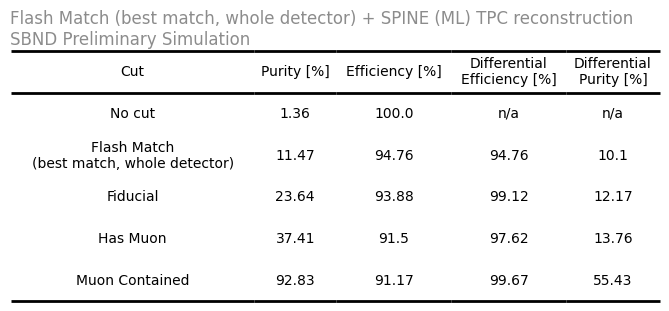

In [21]:
fig,ax = plt.subplots(figsize=(7,3))
ax,table = create_purity_efficiency_table(pur, eff, SPINE_CUT_LABELS_CONT, ax)
plotters.add_label(ax,SPINE_QUALIFIER_PRELIM_LABEL,where=(-0.1,1.07),color='gray',alpha=0.9,fontsize=12)
plotters.save_plot('pur_eff_table_cont_spine',fig=fig,folder_name=f'{PLOT_DIR}/spine_cont')

In [22]:
pur,eff,f1 = inter.get_pur_eff_f1(mcnu,SPINE_CUTS,categories=[0,1])
pur,eff,f1

(array([0.03046694, 0.26291746, 0.53012662, 0.77977275, 0.86736407,
        0.93118669]),
 array([1.        , 0.94402099, 0.91438727, 0.83588359, 0.80227718,
        0.79454086]),
 array([1.        , 0.41128792, 0.67114762, 0.80685382, 0.833552  ,
        0.85745386]))

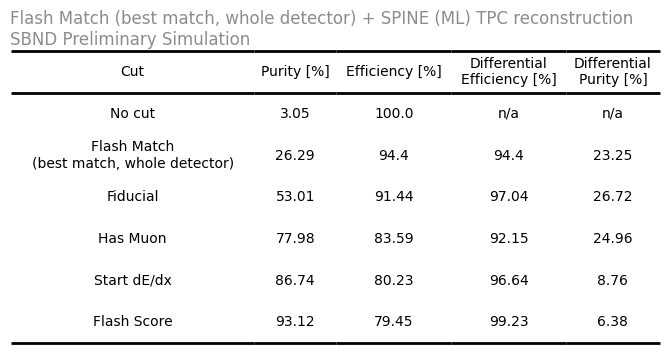

In [23]:
fig,ax = plt.subplots(figsize=(7,3))
ax,table = create_purity_efficiency_table(pur, eff, SPINE_CUT_LABELS, ax)
plotters.add_label(ax,SPINE_QUALIFIER_PRELIM_LABEL,where=(-0.1,1.16),color='gray',alpha=0.9,fontsize=12)
plotters.save_plot('pur_eff_table_uncont_spine',fig=fig,folder_name=f'{PLOT_DIR}/spine_uncont')


In [24]:
cnt = 0
#for cuts,folder,categories in zip([SPINE_CUTS_CONT,SPINE_CUTS,SPINE_CUTS_CONT_NOFM],['spine_cont','spine_uncont','spine_uncont_nofm'],[[0],[0,1],[0]]):
for cuts,folder,categories in zip([SPINE_CUTS_CONT,SPINE_CUTS],['spine_cont','spine_uncont'],[[0],[0,1]]):
  # if cnt > 0:
  #   break
  cnt += 1
  # Make spectra for spine
  _inters = inters
  _inter_weights = inter_weights
  _inter_data = None#inter_data
  data_counts = []

  pur, eff, f1 = inter.get_pur_eff_f1(mcnu, cuts, categories=categories)

  # Initialize variables outside the loop
  _data_events = None
  cut_descriptions = []

  # Pre-compute cut descriptions
  for i, cut in enumerate(['precut'] + cuts):
      cut_desc = f'{cut}:' + '\n' + f'Pur = {pur[i]:.2f}' + '\n' + f'Eff = {eff[i]:.2f}' + '\n' + f'F1 = {f1[i]:.2f}'
      cut_descriptions.append(cut_desc)

  # Main loop - only copy data when we need to apply cuts
  for i, cut in enumerate(['precut'] + cuts):
      print('*' * 70)
      print(f'cut: {cut}')
      
      if cut != 'precut':
          # Only copy when we need to apply cuts
          if i == 1:  # First cut application
              _inters = [s.copy() for s in inters]
              _inter_weights = [w.copy() for w in inter_weights]
              if _inter_data is not None:
                  _inter_data = inter_data.copy()
              else:
                  _inter_data = None
          
          # Apply cuts in batch
          for s in _inters:
              s.apply_cut(cut)
          
          if _inter_data is not None:
              _inter_data.apply_cut(cut)
              _data_events = len(_inter_data.data)
              data_counts.append(_data_events)
              print(f'len(_inter_data): {_data_events}')
          else:
              _data_events = None
      
      # Pre-compute data access
      total_events = np.sum([len(_s.data) for _s in _inters])
      print(f'len(_inters): {total_events}')
      
      # Muon information
      costheta = [s.data.mu.costheta for s in _inters]
      momentum = [s.data.mu.p/1000. for s in _inters] #convert to GeV
      length = [s.data.mu.length for s in _inters]

      # -start and end points
      start_x = [s.data.mu.start_point.x for s in _inters]
      start_y = [s.data.mu.start_point.y for s in _inters]
      start_z = [s.data.mu.start_point.z for s in _inters]
      end_x = [s.data.mu.end_point.x for s in _inters]
      end_y = [s.data.mu.end_point.y for s in _inters]
      end_z = [s.data.mu.end_point.z for s in _inters]

      # -direction
      direction_x = [s.data.mu.start_dir.x for s in _inters]
      direction_y = [s.data.mu.start_dir.y for s in _inters]
      direction_z = [s.data.mu.start_dir.z for s in _inters]
      
      #Interaction information
      flash_score = [1/s.data.flash_scores for s in _inters]
      flash_time = [s.data.flash_times for s in _inters]
      
      # -Vertex information
      interaction_x = [s.data.vertex.x for s in _inters]
      interaction_y = [s.data.vertex.y for s in _inters]
      interaction_z = [s.data.vertex.z for s in _inters]

      _weights = [s.data.genweight for s in _inters]
      if _inter_data is not None:
        # Muon information
        costheta_data = _inter_data.data.mu.costheta
        momentum_data = _inter_data.data.mu.p/1000. #convert to GeV
        length_data = _inter_data.data.mu.length

        # -start and end points
        start_x_data = _inter_data.data.mu.start_point.x
        start_y_data = _inter_data.data.mu.start_point.y
        start_z_data = _inter_data.data.mu.start_point.z
        end_x_data = _inter_data.data.mu.end_point.x
        end_y_data = _inter_data.data.mu.end_point.y
        end_z_data = _inter_data.data.mu.end_point.z

        # -direction
        direction_x_data = _inter_data.data.mu.start_dir.x
        direction_y_data = _inter_data.data.mu.start_dir.y
        direction_z_data = _inter_data.data.mu.start_dir.z

        # Interaction information
        flash_score_data = 1/_inter_data.data.flash_scores
        flash_time_data = _inter_data.data.flash_times

        # -Vertex information
        vertex_x_data = _inter_data.data.vertex.x
        vertex_y_data = _inter_data.data.vertex.y
        vertex_z_data = _inter_data.data.vertex.z

      else:
        costheta_data = None
        momentum_data = None
        length_data = None
        start_x_data = None
        start_y_data = None
        start_z_data = None
        end_x_data = None
        end_y_data = None
        end_z_data = None
        direction_x_data = None
        direction_y_data = None
        direction_z_data = None
        flash_score_data = None
        flash_time_data = None
        vertex_x_data = None
        vertex_y_data = None
        vertex_z_data = None
      
      # Use pre-computed cut description
      cut_desc = cut_descriptions[i]
      
      # Create plots for both density and counts
      for dens in [True, False]:
          plot_dir = f'{PLOT_DIR}/{folder}/{cut}/{"dens" if dens else "counts"}'
          
          # Costheta
          fig, ax = create_hist(
              costheta, labels, dens,
              data_series=costheta_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\cos\theta_{\mu}$',
              label=SPINE_QUALIFIER_PRELIM_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-1, 1.1, 0.1),
              cut=cut,
              savename='costhetamu',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )
          
          # Momentum
          fig, ax = create_hist(
              momentum, labels, dens,
              data_series=momentum_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Momentum [GeV/c]',
              label=SPINE_QUALIFIER_PRELIM_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(0, 2.6, 0.1),
              cut=cut,
              savename='pmu',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Length
          fig, ax = create_hist(
              length, labels, dens,
              data_series=length_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Length [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(0, 700, 5),
              cut=cut,
              savename='reco_length',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Start x
          fig, ax = create_hist(
              start_x, labels, dens,
              data_series=start_x_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Start X [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-250, 350, 5),
              cut=cut,
              savename='reco_start_x',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Start y
          fig, ax = create_hist(
              start_y, labels, dens,
              data_series=start_y_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Start Y [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-250, 350, 5),
              cut=cut,
              savename='reco_start_y',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Start z
          fig, ax = create_hist(
              start_z, labels, dens,
              data_series=start_z_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Start Z [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-50, 650, 5),
              cut=cut,
              savename='reco_start_z',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -End x
          fig, ax = create_hist(
              end_x, labels, dens,
              data_series=end_x_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ End X [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-250, 250, 5),
              cut=cut,
              savename='reco_end_x',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -End y
          fig, ax = create_hist(
              end_y, labels, dens,
              data_series=end_y_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ End Y [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-250, 250, 5),
              cut=cut,
              savename='reco_end_y',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -End z
          fig, ax = create_hist(
              end_z, labels, dens,
              data_series=end_z_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ End Z [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-50, 650, 5),
              cut=cut,
              savename='reco_end_z',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Direction x
          fig, ax = create_hist(
              direction_x, labels, dens,
              data_series=direction_x_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Direction X',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-1, 1.5, 0.1),
              cut=cut,
              savename='reco_direction_x',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Direction y
          fig, ax = create_hist(
              direction_y, labels, dens,
              data_series=direction_y_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Direction Y',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-1, 1.5, 0.1),
              cut=cut,
              savename='reco_direction_y',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Direction z
          fig, ax = create_hist(
              direction_z, labels, dens,
              data_series=direction_z_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed $\mu$ Direction Z',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-1, 1.5, 0.1),
              cut=cut,
              savename='reco_direction_z',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Interaction x
          fig, ax = create_hist(
              interaction_x, labels, dens,
              data_series=interaction_x_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed Interaction X [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-250, 350, 5),
              cut=cut,
              savename='reco_interaction_x',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Interaction y
          fig, ax = create_hist(
              interaction_y, labels, dens,
              data_series=interaction_y_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed Interaction Y [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-250, 350, 5),
              cut=cut,
              savename='reco_interaction_y',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Interaction z
          fig, ax = create_hist(
              interaction_z, labels, dens,
              data_series=interaction_z_data,
              cut_desc=cut_desc,
              xlabel=r'Reconstructed Interaction Z [cm]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-50, 650, 5),
              cut=cut,
              savename='reco_interaction_z',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

          # -Flash score
          fig, ax = create_hist(
              flash_score, labels, dens,
              data_series=flash_score_data,
              cut_desc=cut_desc,
              xlabel=r'OpT0 $\chi^2$ (1/Score)',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.logspace(-5,2,120),
              cut=cut,
              savename=None,
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )
          #Customize plot
          ax.set_xscale('log')
          plotters.save_plot('opt0_score',fig=fig,folder_name=plot_dir)
          plt.close(fig)

          # -Flash time
          fig, ax = create_hist(
              flash_time, labels, dens,
              data_series=flash_time_data,
              cut_desc=cut_desc,
              xlabel=r'Flash Time [ns]',
              label=SPINE_QUALIFIER_INTERNAL_LABEL,
              colors=colors,
              weights=_weights,
              bins=np.arange(-3, 3.1, 0.1),
              cut=cut,
              savename='opt0_time',
              plot_dir=plot_dir,
              data_events=_data_events,
              show_counts=not dens
          )

**********************************************************************
cut: precut
len(_inters): 2339120


**********************************************************************
cut: cosmic
Applied cut on key: cut.cosmic (27,864 --> 25,538)
Applied cut on key: cut.cosmic (55,791 --> 33,069)
Applied cut on key: cut.cosmic (31,206 --> 22,477)
Applied cut on key: cut.cosmic (67,683 --> 46,686)
Applied cut on key: cut.cosmic (1,069 --> 672)
Applied cut on key: cut.cosmic (40,419 --> 25,168)
Applied cut on key: cut.cosmic (2,115,088 --> 36,804)
len(_inters): 190414
**********************************************************************
cut: fv
Applied cut on key: cut.fv (25,538 --> 25,285)
Applied cut on key: cut.fv (33,069 --> 31,453)
Applied cut on key: cut.fv (22,477 --> 5,694)
Applied cut on key: cut.fv (46,686 --> 11,375)
Applied cut on key: cut.fv (672 --> 530)
Applied cut on key: cut.fv (25,168 --> 19,560)
Applied cut on key: cut.fv (36,804 --> 8,193)
len(_inters): 102090
**********************************************************************
cut: muon
Applied cut on key: cut.muon (25,285 -

## 5. Pandora SPINE comp

In [ ]:
#Get slices with all cuts applied
slc_cut = slc.copy()
slc_cut.cut_all(False,cut=True)
slc_cont_cut = slc_cut.copy()
slc_cont_cut.cut_all(cont=True,cut=True)

In [ ]:
#Get interaction slices with all cuts applied
inter_cut = inter.copy()
inter_cut.cut_all(False,cut=True)
inter_cont_cut = inter.copy()
inter_cont_cut.cut_all(cont=True,cut=True)

### 5.1. Track flipping

In [139]:
inter_cut.add_track_flipping()
inter_cont_cut.add_track_flipping()
slc_cut.add_track_flipping()
slc_cont_cut.add_track_flipping()

[0. 1. 0. ... 0. 0. 0.]
condition: [ True  True  True ...  True  True  True]
value: [0. 1. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
condition: [ True  True  True ...  True  True  True]
value: [0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
condition: [ True  True  True ...  True  True  True]
value: [0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
condition: [ True  True  True ...  True  True  True]
value: [0. 0. 1. ... 0. 0. 0.]


In [149]:
inter_cut.data.mu.is_flipped.value_counts(normalize=True),slc_cut.data.mu.pfp.trk.is_flipped.value_counts(normalize=True),slc_cont_cut.data.mu.pfp.trk.is_flipped.value_counts(normalize=True)

(is_flipped
 0.0    0.94183
 1.0    0.05817
 Name: proportion, dtype: float64,
 is_flipped
 0.0    0.943211
 1.0    0.056789
 Name: proportion, dtype: float64,
 is_flipped
 0.0    0.942574
 1.0    0.057426
 Name: proportion, dtype: float64)

In [154]:
m = inter_cut.data.num_primary_particles_x == 21
inter_cut.data[m].run.iloc[0],inter_cut.data[m].subrun.iloc[0],inter_cut.data[m].evt.iloc[0]


(30.0, 1.0, 85.0)

Total events: 26482
Total flipped tracks: 1994.0
Overall flipping fraction: 0.0753
Number of bins with data: 17


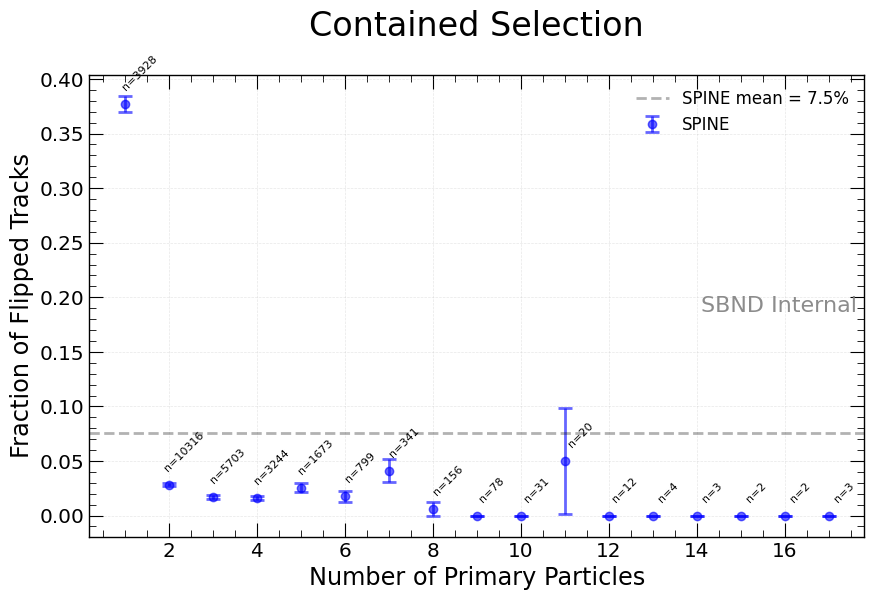

In [156]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the data
x_spine = inter_cont_cut.data.num_primary_particles_x
y_spine = inter_cont_cut.data.mu.is_flipped
#x_pand = slc_cut.data.num_primary_particles_x

# Create bins for num_primary_particles_y
# You might want to adjust these bins based on your data range
bins = np.arange(1, x_spine.max() + 2, 1)  # Adjust binning as needed

# Calculate the fraction of flipped tracks in each bin
bin_centers = (bins[:-1] + bins[1:]) / 2
fractions = []
bin_counts = []
errors = []

for i in range(len(bins) - 1):
    mask = (x_spine >= bins[i]) & (x_spine < bins[i + 1])
    if mask.sum() > 0:  # Only include bins with data
        flipped_count = y_spine[mask].sum()
        total_count = mask.sum()
        fraction = flipped_count / total_count
        # Binomial error
        error = np.sqrt(fraction * (1 - fraction) / total_count)
        
        fractions.append(fraction)
        bin_counts.append(total_count)
        errors.append(error)
    else:
        fractions.append(np.nan)
        bin_counts.append(0)
        errors.append(0)

# Convert to numpy arrays and remove NaN values
fractions = np.array(fractions)
bin_counts = np.array(bin_counts)
errors = np.array(errors)

# Remove bins with no data
valid_mask = bin_counts > 0
fractions = fractions[valid_mask]
bin_centers = bin_centers[valid_mask]
errors = errors[valid_mask]
bin_counts = bin_counts[valid_mask]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
ax.errorbar(bin_centers-0.5, fractions, yerr=errors, fmt='o', capsize=5, capthick=2, 
           markersize=6, linewidth=2, color='blue', label='SPINE',alpha=0.6)

# Add some styling
ax.set_xlabel('Number of Primary Particles')
ax.set_ylabel('Fraction of Flipped Tracks')
ax.set_title('Contained Selection')
ax.grid(True, alpha=0.3)
ax.axhline(y_spine.mean(),color='black',linestyle='--',label=f'SPINE mean = {y_spine.mean()*100:.1f}%',alpha=0.3)
ax.legend()

# Add text showing total number of events in each bin
for i, (x, y, count) in enumerate(zip(bin_centers, fractions, bin_counts)):
    ax.annotate(f'n={count}', (x-0.15, y), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8, alpha=1.,rotation=45)

# Add label because this is a plot to keep
plotters.add_label(ax,LABEL,where='centerright',color='gray',alpha=0.9,fontsize=16)

# Print some summary statistics
print(f"Total events: {len(x_spine)}")
print(f"Total flipped tracks: {y_spine.sum()}")
print(f"Overall flipping fraction: {y_spine.mean():.4f}")
print(f"Number of bins with data: {len(bin_centers)}")

plotters.save_plot('spine_track_flipping_cont',fig=fig,folder_name=f'{PLOT_DIR}')

In [109]:
inter_cut.data.num_primary_particles_y.value_counts()

num_primary_particles_y
0.0    52329
Name: count, dtype: int64

## Testing

/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/plotlibrary/makeplot.py:186: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist/norms


(<Figure size 700x500 with 2 Axes>,
 <Axes: xlabel='True class', ylabel='Predicted class'>)

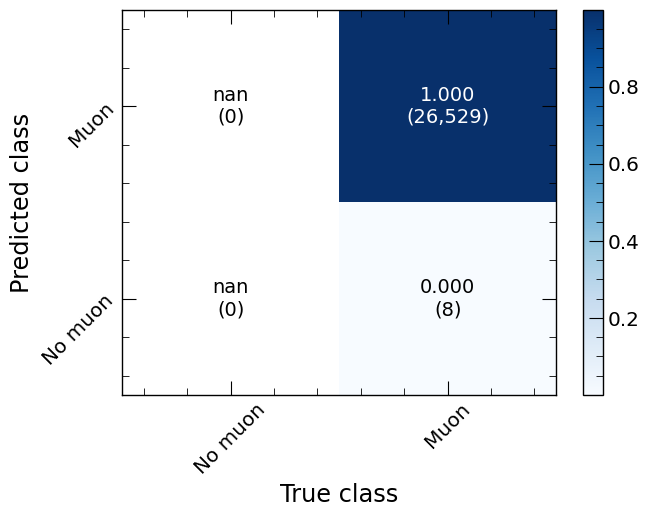

In [ ]:
from sbnd.plotlibrary import makeplot
m = np.isin(slc.data.truth.event_type,[0])
x = slc.data[m].cut.muon
y = (slc.data[m].truth.nmu_100MeV > 0)
hist = np.histogram2d(x,y,bins=[2,2])[0]
makeplot.draw_confusion_matrix_binned(hist,norm_ax=0,class_names=['No muon','Muon'])

(0.04, 0.11)

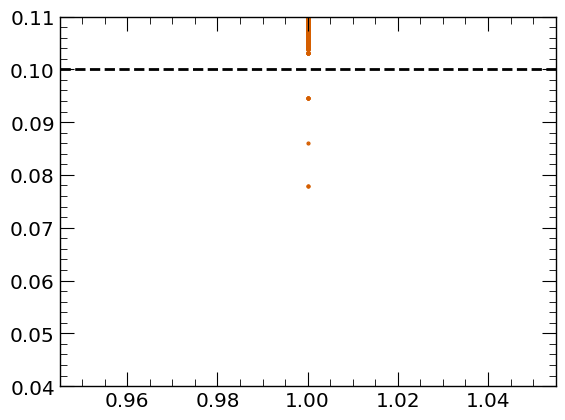

In [ ]:
from sbnd.general import utils
utils.calc_ke_from_momentum(slc.data[m].mu.pfp.trk.P.p_muon.describe(),PDG_TO_MASS_MAP[13])
fig,ax = plt.subplots()
xs = [1]*len(slc.data[m].mu.pfp.trk.P.p_muon)
ax.scatter(xs,utils.calc_ke_from_momentum(slc.data[m].mu.pfp.trk.P.p_muon,PDG_TO_MASS_MAP[13]),s=1)
ax.axhline(0.1,color='black',linestyle='--')
ax.set_ylim([0.04,.11])

/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/plotlibrary/makeplot.py:186: RuntimeWarning: invalid value encountered in divide
  hist_norm = hist/norms


(<Figure size 700x500 with 2 Axes>,
 <Axes: xlabel='True class', ylabel='Predicted class'>)

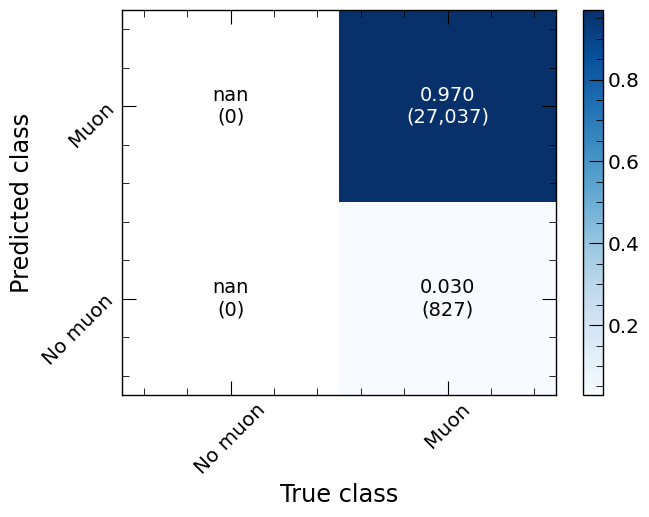

In [ ]:
m = np.isin(inter.data.truth.event_type,[0])
x = inter.data[m].cut.muon
y = (inter.data[m].truth.nmu_100MeV > 0)
hist = np.histogram2d(x,y,bins=[2,2])[0]
makeplot.draw_confusion_matrix_binned(hist,norm_ax=0,class_names=['No muon','Muon'])

In [ ]:
inter.add_key(['start_diff','end_diff','tpart_start_diff','tpart_end_diff','reco_tpart_start_diff','reco_tpart_end_diff'],
fill=np.array([np.linalg.norm(inter.data.mu.start_point.values-inter.data.truth.mu.start.values,axis=1),
np.linalg.norm(inter.data.mu.end_point.values-inter.data.truth.mu.end.values,axis=1),
np.linalg.norm(inter.data.mu.tpart.start_point.values-inter.data.truth.mu.start.values,axis=1),
np.linalg.norm(inter.data.mu.tpart.end_point.values-inter.data.truth.mu.end.values,axis=1),
np.linalg.norm(inter.data.mu.tpart.start_point.values-inter.data.mu.start_point.values,axis=1),
np.linalg.norm(inter.data.mu.tpart.end_point.values-inter.data.mu.end_point.values,axis=1)]).T)

/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/sbnd/cafclasses/parent.py:175: PerformanceWarning: indexing past lexsort depth may impact performance.
  cols_to_add = {col: updated_df[col] for col in new_cols}


ValueError: If using all scalar values, you must pass an index

In [ ]:
inter.add_key(['reco_tpart_start_diff','reco_tpart_end_diff'],
fill=np.array([
np.linalg.norm(inter.data.mu.tpart.start_point.values-inter.data.mu.start_point.values,axis=1),
np.linalg.norm(inter.data.mu.tpart.end_point.values-inter.data.mu.end_point.values,axis=1)]).T)

In [ ]:
keys = [
#   ('mu', 'start_point', 'x', '', '', ''),
# ('mu', 'start_point', 'y', '', '', ''),
# ('mu', 'start_point', 'z', '', '', ''),
('mu', 'tpart', 'start_point', 'x', '', ''),
('mu', 'tpart', 'start_point', 'y', '', ''),
('mu', 'tpart', 'start_point', 'z', '', ''),
('truth', 'mu', 'start', 'x', '', ''),
('truth', 'mu', 'start', 'y', '', ''),
('truth', 'mu', 'start', 'z', '', ''),
('start_diff', '', '', '', '', ''),
('tpart_start_diff', '', '', '', '', ''),
# ('mu', 'end_point', 'x', '', '', ''),
# ('mu', 'end_point', 'y', '', '', ''),
# ('mu', 'end_point', 'z', '', '', ''),
('mu', 'tpart', 'end_point', 'x', '', ''),
('mu', 'tpart', 'end_point', 'y', '', ''),
('mu', 'tpart', 'end_point', 'z', '', ''),
('truth', 'mu', 'end', 'x', '', ''),
('truth', 'mu', 'end', 'y', '', ''),
('truth', 'mu', 'end', 'z', '', ''),
('end_diff', '', '', '', '', ''),
('tpart_end_diff', '', '', '', '', ''),
('mu', 'is_contained', '', '', '', ''),
('truth', 'mu', 'is_contained_y', '', '', '')]
inter.data.loc[m2,keys]

mu                               truth  \
                                    tpart                                  mu   
                              start_point                               start   
                                        x           y           z           x   
                                                                                
                                                                                
__ntuple entry rec.dlp..index                                                   
1        8     11             -108.449997   -4.049988  232.550018 -108.419174   
         46    1               -36.750000  -98.850006  145.250000  -37.085815   
         68    2                17.850006  -10.950012  229.550018   18.530804   
         76    8                 7.250000  -72.182251  431.549988    7.129106   
         90    4               -88.949997  -31.049988  398.450012  -89.634628   
..                                    ...         ...         ...         ...   
15       8794  6               -32.549988  173.850006   30.949989  -32.767109   
         8815  0              -163.649994   28.649994    5.149998 -129.912781   
         8824  5               -17.250000  198.750000  363.649994   84.652756   
         8839  3              -130.449997  -44.582245  436.649994 -130.555954   
         8853  7              -180.550003  -77.582245   81.150002 -180.581970   

                                                       start_diff  \
                                                                    
                                                                    
                                        y           z               
                                                                    
                                                                    
__ntuple entry rec.dlp..index                                       
1        8     11               -4.451747  232.179733    0.733577   
         46    1               -99.122520  144.865356    0.809814   
         68    2               -10.874552  229.689804    1.044906   
         76    8               -72.275887  431.545502    1.431674   
         90    4               -31.062401  398.647247    0.901967   
..                                    ...         ...         ...   
15       8794  6               174.206940   30.523247    1.108500   
         8815  0              -110.748253   43.120018  119.675667   
         8824  5                82.345284  282.770996  175.166077   
         8839  3               -44.451351  436.542236    0.868350   
         8853  7               -77.481544   81.283020    0.551762   

                              tpart_start_diff          mu              \
                                                     tpart               
                                                 end_point               
                                                         x           y   
                                                                         
                                                                         
__ntuple entry rec.dlp..index                                            
1        8     11                     0.547240 -201.149994  -19.350006   
         46    1                      0.578780  -94.949997  187.049957   
         68    2                      0.699085  -51.750000 -110.850006   
         76    8                      0.152981   24.750000  -92.850006   
         90    4                      0.712584   20.549988  -42.750000   
..                                         ...         ...         ...   
15       8794  6                      0.597204    9.750000  199.049957   
         8815  0                    148.363724 -134.850006 -199.949997   
         8824  5                    174.572739   76.649994 -199.949997   
         8839  3                      0.199929 -100.649979  -33.750000   
         8853  7                      0.169872 -201.149994  -55.949997   

    

In [ ]:
def plot_start_end_points(start_x,start_y,end_x,end_y,ax,label='',colors=['blue','red'],markers=['o','x']):
  ax.plot([start_x,end_x],[start_y,end_y],c='black',alpha=0.5)
  ax.scatter(start_x,start_y,c=colors[0],label=f'{label} start',marker=markers[0])
  ax.scatter(end_x,end_y,c=colors[1],label=f'{label} end',marker=markers[1])

Text(0, 0.5, 'Y [cm]')

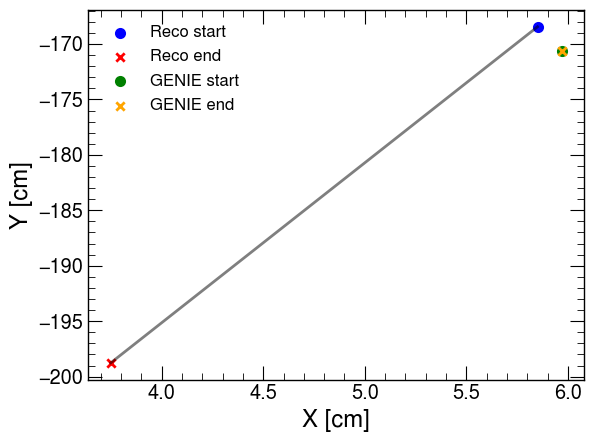

In [ ]:
#Plot start and end points for first m-n events
m=94
n = 95
fig,ax = plt.subplots()

plot_start_end_points(inter.data[m2].iloc[m:n].mu.start_point.x,inter.data[m2].iloc[m:n].mu.start_point.y,inter.data[m2].iloc[m:n].mu.end_point.x,inter.data[m2].iloc[m:n].mu.end_point.y,ax,'Reco')
plot_start_end_points(inter.data[m2].iloc[m:n].truth.mu.start.x,inter.data[m2].iloc[m:n].truth.mu.start.y,inter.data[m2].iloc[m:n].truth.mu.end.x,inter.data[m2].iloc[m:n].truth.mu.end.y,ax,'GENIE',colors=['green','orange'])


ax.legend()
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')


In [ ]:
dx = 2
endx = 400+dx
bins = np.arange(0,endx,dx)

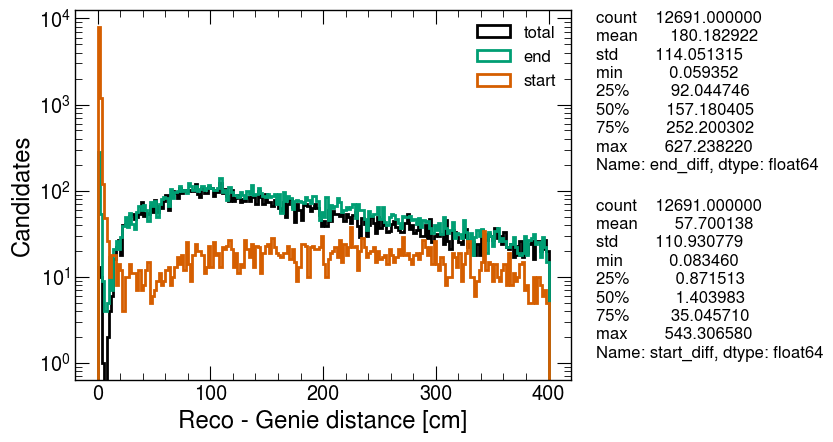

In [ ]:
fig,ax = plt.subplots()
ax.hist([inter.data[m2].start_diff,inter.data[m2].end_diff,inter.data[m2].start_diff+inter.data[m2].end_diff],
bins=bins,histtype='step',label=['start','end','total'])
ax.legend()
ax.set_xlabel('Reco - Genie distance [cm]')
ax.set_ylabel('Candidates')
ax.set_yscale('log')
plotters.add_label(ax,inter.data[m2].start_diff.describe(),where='bottomrightoutside',color='black',alpha=1.,fontsize=12)
plotters.add_label(ax,inter.data[m2].end_diff.describe(),where=(1.05,1.0),horizontalalignment='left',verticalalignment='top',color='black',alpha=1.,fontsize=12)


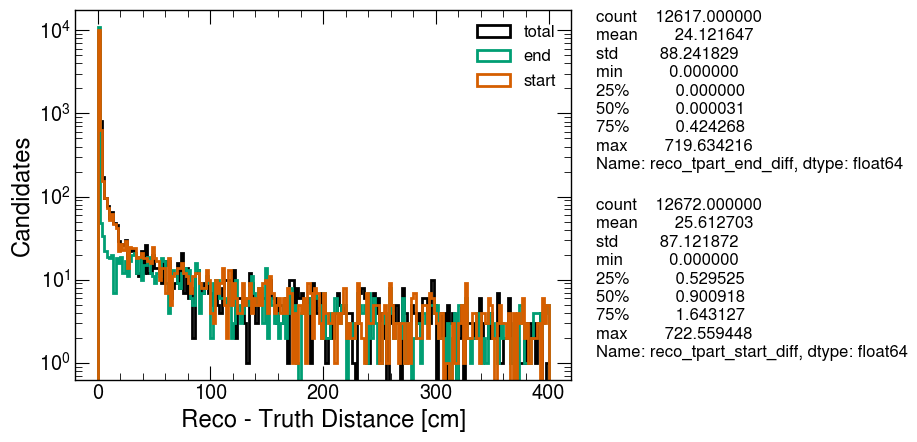

In [ ]:
fig,ax = plt.subplots()
ax.hist([inter.data[m2].reco_tpart_start_diff,inter.data[m2].reco_tpart_end_diff,
inter.data[m2].reco_tpart_start_diff+inter.data[m2].reco_tpart_end_diff],
bins=bins,histtype='step',label=['start','end','total'])
ax.legend()
ax.set_xlabel('Reco - Truth Distance [cm]')
ax.set_ylabel('Candidates')
ax.set_yscale('log')


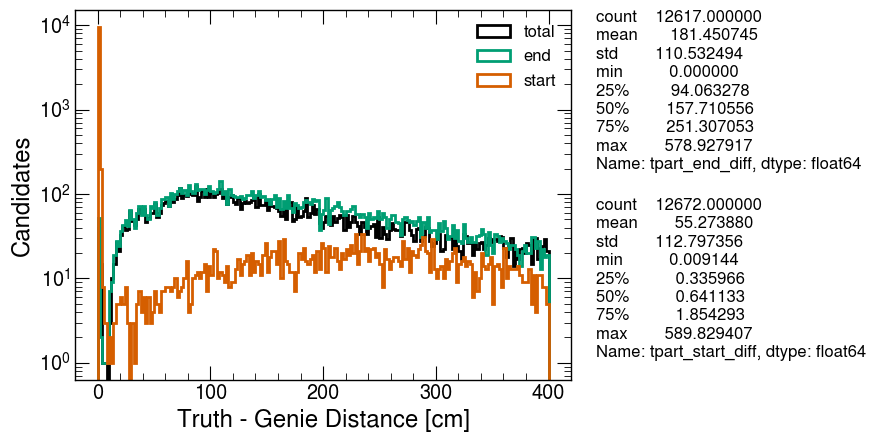

In [ ]:
fig,ax = plt.subplots()
ax.hist([inter.data[m2].tpart_start_diff,inter.data[m2].tpart_end_diff,
inter.data[m2].tpart_start_diff+inter.data[m2].tpart_end_diff],
bins=bins,histtype='step',label=['start','end','total'])
ax.legend()
ax.set_xlabel('Truth - Genie Distance [cm]')
ax.set_ylabel('Candidates')
ax.set_yscale('log')
plotters.add_label(ax,inter.data[m2].tpart_start_diff.describe(),where='bottomrightoutside',color='black',alpha=1.,fontsize=12)
plotters.add_label(ax,inter.data[m2].tpart_end_diff.describe(),where=(1.05,1.0),horizontalalignment='left',verticalalignment='top',color='black',alpha=1.,fontsize=12)


In [67]:
inter.data[inter.data.truth.event_type == 2].truth.mu

genE      length   pdg      genp            \
                                                                  x         y   
                                                                                
                                                                                
__ntuple entry rec.dlp..index                                                   
1        9     7               0.836102   64.967857  13.0  0.369061  0.014930   
         24    0               0.183395   21.135117  13.0 -0.090329 -0.024837   
         59    3               0.417206  133.046753  13.0 -0.128032 -0.256674   
               9               0.417206  133.046753  13.0 -0.128032 -0.256674   
         64    4               1.049774  187.802856  13.0  0.460311  0.392689   
...                                 ...         ...   ...       ...       ...   
15       8830  11              0.190907   25.002033  13.0  0.081443  0.133633   
         8835  7               0.272202   30.081207  13.0  0.029259  0.209985   
         8837  2               0.148236    8.746511  13.0  0.040789 -0.094250   
         8840  12              0.363769    4.508608  13.0 -0.159537 -0.051515   
         8843  0               0.480621   11.524347  13.0 -0.193749  0.339296   

                                              start                          \
                                      z           x           y           z   
                                                                              
                                                                              
__ntuple entry rec.dlp..index                                                 
1        9     7               0.742613  -92.022346  -71.792648  452.113525   
         24    0               0.117021   67.030502 -105.277679  147.498840   
         59    3               0.283942  195.113892  -45.169132   48.678913   
               9               0.283942  195.113892  -45.169132   48.678913   
         64    4               0.851335 -193.205002  130.081512  327.474823   
...                                 ...         ...         ...         ...   
15       8830  11              0.028125 -192.543152  -56.604153   91.866310   
         8835  7               0.134091  133.242599  177.588974  493.629852   
         8837  2              -0.016227  181.824387  146.393784  454.951233   
         8840  12              0.305055 -199.261093   37.168339  163.481293   
         8843  0               0.259176 -168.202728  195.412613   94.865112   

                                      end                              totp  \
                                        x           y           z             
                                                                              
                                                                              
__ntuple entry rec.dlp..index                                                 
1        9     7               -61.414787  -72.502739  509.399994  0.829399   
         24    0                58.832581 -109.416519  166.356781  0.149900   
         59    3               148.605164 -118.385246  149.102234  0.403605   
               9               148.605164 -118.385246  149.102234  0.403605   
         64    4              -108.275078  203.732254  477.851746  1.044443   
...                                   ...         ...         ...       ...   
15       8830  11             -177.900269  -37.040226   96.969849  0.159002   
         8835  7               133.242599  177.588974  493.629852  0.250859   
         8837  2               185.406296  138.649582  453.028015  0.103972   
         8840  12             -201.300003   36.385731  167.425522  0.348087   
         8843  0              -172.931442  203.732254  101.286278  0.468863   

                                    dir                     is_contained_y  
                                      x         y         z                 
                                                      

In [ ]:
inter.data.truth.E.isna().sum()

(94949, 0)

In [30]:
inter.data.truth.iscc.value_counts(),slc.data.iscc.value_counts()

(iscc
 1.0    9309
 0.0    2528
 Name: count, dtype: int64,
 iscc
 1.0    6630
 0.0    1141
 Name: count, dtype: int64)

In [39]:
run, subrun, evt = 3,12,23
inter.data.loc[inter.data.run == run,inter.data.subrun == subrun,inter.data.evt == evt].truth.loc[:,["pdg","event_type"]]

pdg event_type
                                              
                                              
                                              
                                              
__ntuple entry rec.dlp..index                 
0        2     0                NaN          6
               1               14.0          3
               2                NaN          6
               3                NaN          6
               4                NaN          6
               5                NaN          6
               6                NaN          6
               7                NaN          6
               8                NaN          6
               9               14.0          3
               10               NaN          6
               11              14.0          3
               12              14.0          3
               13               NaN          6

In [43]:
slc.data.loc[slc.data.run == run,slc.data.subrun == subrun,slc.data.evt == evt].truth.event_type

__ntuple  entry  rec.slc..index
0         2      0                 6
                 1                 6
                 2                 3
                 3                 6
                 4                 6
                 5                 6
                 6                 6
                 7                 6
                 8                 6
                 9                 3
Name: event_type, dtype: int64

In [34]:
inter.data.loc[inter.data.truth.iscc == 1,["run","subrun","evt"]].drop_duplicates(),slc.data.loc[slc.data.iscc == 1,["run","subrun","evt"]].drop_duplicates()


(                              run subrun  evt
                                              
                                              
                                              
                                              
                                              
 __ntuple entry rec.dlp..index                
 0        0     1                3     12    5
          1     3                3     12   19
          2     1                3     12   23
          3     12               3     12   25
          4     0                3     12   27
 ..                             ..    ...  ...
          8689  1               36     85   77
          8691  11              36     85   92
          8692  8               36     85   93
          8693  1               36     85   95
          8694  3               36     85  100
 
 [6768 rows x 3 columns],
                               run subrun  evt
                                              
                                

[[71271.   405.]
 [  846.  2821.]]


(<Figure size 700x500 with 2 Axes>,
 <Axes: xlabel='True class', ylabel='Predicted class'>)

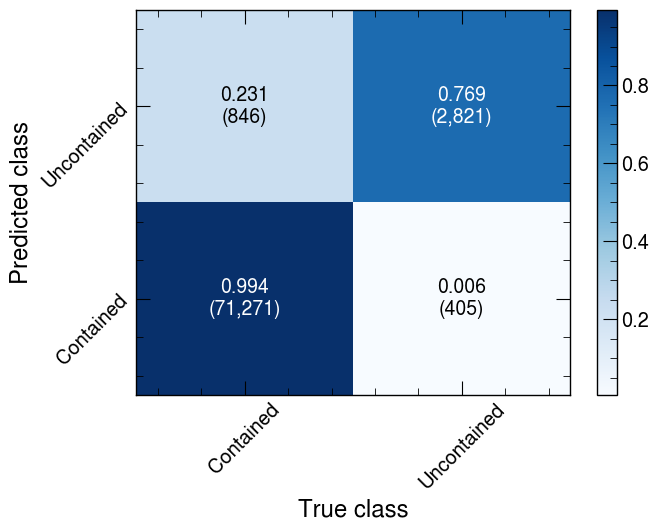

In [330]:
from sbnd.plotlibrary import makeplot
x = inter.data.mu.tpart.is_contained.values
y = inter.data.mu.is_contained.values

# x = inter.data.mu.is_primary
# y = inter.data.mu.truth.is_primary

hist = np.histogram2d(x,y,bins=[0,1,2])[0]
print(hist)

makeplot.draw_confusion_matrix_binned(hist,
class_names=['Contained','Uncontained'],
show_counts=True,
norm_ax=1
)

In [316]:
inter.data.truth.av.value_counts()
inter.data.truth.iscc.value_counts()
inter.data.truth.pdg.value_counts()

pdg
 14.0    11635
-14.0      124
 12.0       78
Name: count, dtype: int64

<Axes: >

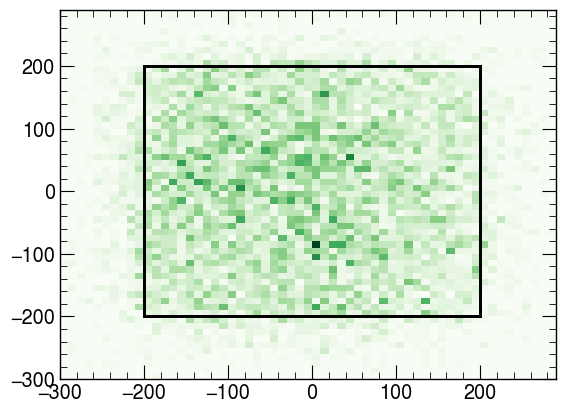

In [307]:
from sbnd.detector.volume import plot_volume_boundary

x = inter.data[~inter.data.truth.position.x.isna()].truth.position.x.values
y = inter.data[~inter.data.truth.position.y.isna()].truth.position.y.values

plt.hist2d(x,y,bins=np.arange(-300,300,10))
plot_volume_boundary(volume=AV,ax=plt.gca(),color='k')


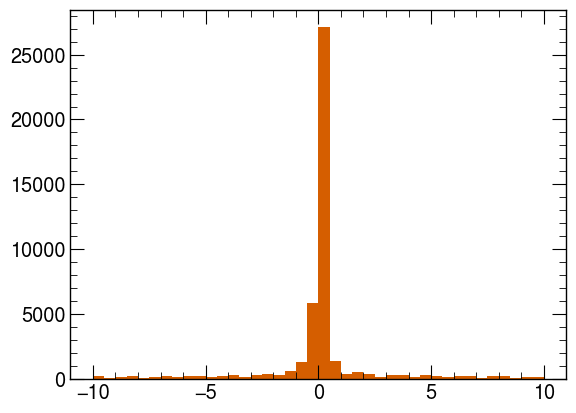

In [298]:
x = inter.data.mu.start_point.x
y = inter.data.mu.tpart.start_point.x

plt.hist(x-y,bins=np.arange(-10,10.5,0.5));

In [252]:
x.value_counts()

is_primary
1.0    81433
Name: count, dtype: int64

pid
2.0    81433
Name: count, dtype: int64

In [111]:
slc.data.mu.pfp.trk.truth.p.contained.value_counts()

contained
0.0    74
Name: count, dtype: int64

In [112]:
slc.data

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        0     0                            0   44.682514   85.553917   
               1                            0 -108.213371   82.100555   
               2                            0  140.860611 -199.704239   
               3                            0  166.353241   85.611969   
         1     0                            0 -200.000015 -150.731308   
..                                        ...         ...         ...   
         46    2                            0  161.198608  -50.728352   
         47    0                            0 -162.853439  111.342255   
               1                            0  157.174423  111.419601   
         48    0                            0  201.545013  -44.602688   
         49    0                            0 -123.812195   40.468098   

                                                                        \
                                          self tmatch         producer   
                                        z         eff pur idx            
                                                                         
                                                                         
                                                                         
                                                                         
                                                                         
__ntuple entry rec.slc..index                                            
0        0     0               415.433075   75    NaN NaN NaN        0   
               1               222.558105   76    NaN NaN NaN        0   
               2               152.417953   77    NaN NaN NaN        0   
               3               372.661713   74    NaN NaN NaN        0   
         1     0               274.906067   40    NaN NaN NaN        0   
..                                    ...  ...    ...  ..  ..      ...   
         46    2               505.262238   55    NaN NaN NaN        0   
         47    0               155.500870   56    NaN NaN NaN        0   
               1               301.480438   55    NaN NaN NaN        0   
         48    0               113.595673   91    NaN NaN NaN        0   
         49    0               143.710419   35    NaN NaN NaN        0   

                                             ... has_muon  truth vertex  \
                                       nuid  ...              av     av   
                              crlongtrkdiry  ...                          
                                             ...                          
                                             ...                          
                                             ...                          
                                             ...                          
                                             ...                          
__ntuple entry rec.slc..index                ...                          
0        0     0                  -0.564175  ...     True  False   True   
               1                  -0.812124  ...    False  False   True   
               2                  -0.205903  ...     True  False   True   
               3                  -0.288523  ...    False  False   True   
         1     0                  -0.431574  ...     True  False  False   
..                                      ...  ...  

In [333]:
hdr = pd.read_hdf(f'{DATA_DIR}/{FNAME}',key='hdr_0')
hdr.keys()

Index(['pot', 'first_in_subrun', 'ismc', 'run', 'subrun', 'ngenevt', 'evt',
       'proc', 'cluster', 'fno', 'noffbeambnb'],
      dtype='object')

In [336]:
from pyanalib.pandas_helpers import multicol_merge
multicol_merge(slc.data,hdr,left_index=True,right_index=True,how='left',validate='one_to_one')

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        0     0                            0  -93.493523 -144.838104   
               1                            0   53.705078   80.129021   
               2                            1 -127.981506  194.451080   
               3                            1  119.970314   55.909958   
               4                            1  -98.942528   18.080561   
..                                        ...         ...         ...   
         8694  2                            1 -192.610367  200.018951   
               3                            1   62.823784  193.182098   
               4                            1  -11.126747  204.403854   
               5                            1  -33.300854  -71.126671   
               6                            1  212.073074 -105.238426   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        0     0                 3.480694   39       NaN       NaN  NaN   
               1               281.692993   38  0.849065  0.995891  1.0   
               2                 4.162482    1       NaN       NaN  NaN   
               3               330.043030    2       NaN       NaN  NaN   
               4                 2.862590    3       NaN       NaN  NaN   
..                                    ...  ...       ...       ...  ...   
         8694  2               107.239998    0       NaN       NaN  NaN   
               3               236.257477    1       NaN       NaN  NaN   
               4               405.795410    2       NaN       NaN  NaN   
               5                77.449585    3       NaN       NaN  NaN   
               6                 4.321503    4       NaN       NaN  NaN   

                                                      ... first_in_subrun  \
                              producer          nuid  ...                   
                                       crlongtrkdiry  ...                   
                                                      ...                   
                                                      ...                   
                                                      ...                   
                                                      ...                   
                                                      ...                   
__ntuple entry rec.slc..index                         ...                   
0        0     0                     0     -0.222321  ...               1   
               1                     0      0.200520  ...               1   
               2                     0           NaN  ...               1   
               3                     0           NaN  ...               1   
               4                     0           NaN  ...               1   
..

In [332]:
slc.data.head()

slc                          \
                              is_clear_cosmic      vertex               
                                                        x           y   
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
__ntuple entry rec.slc..index                                           
0        0     0                            0  -93.493523 -144.838104   
               1                            0   53.705078   80.129021   
               2                            1 -127.981506  194.451080   
               3                            1  119.970314   55.909958   
               4                            1  -98.942528   18.080561   

                                                                         \
                                          self    tmatch                  
                                        z            eff       pur  idx   
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        0     0                 3.480694   39       NaN       NaN  NaN   
               1               281.692993   38  0.849065  0.995891  1.0   
               2                 4.162482    1       NaN       NaN  NaN   
               3               330.043030    2       NaN       NaN  NaN   
               4                 2.862590    3       NaN       NaN  NaN   

                                                      ...        vertex  \
                              producer          nuid  ...  truth     av   
                                       crlongtrkdiry  ...     av          
                                                      ...                 
                                                      ...                 
                                                      ...                 
                                                      ...                 
                                                      ...                 
__ntuple entry rec.slc..index                         ...                 
0        0     0                     0     -0.222321  ...  False   True   
               1                     0      0.200520  ...   True   True   
               2                     0           NaN  ...  False   True   
               3                     0           NaN  ...  False   True   
               4                     0           NaN  ...  False   True   

                                 slc vertex    cut                       \
                               truth     fv cosmic     fv  truth   muon   
                                  fv                          fv          
                                                                          
                                                                          
                                                                          
                                                                          
                                                                          
__ntuple entry rec.slc..index                                             
0        0     0               False  False  False  False  False   True   
               1                True   True   True   True   True   True   
               2               False  False  False  False  False  False   
               3 

In [76]:
slc.data.mu.pfp.trk.is_muon == True

__ntuple  entry  rec.slc..index
0         0      0                  True
                 1                 False
                 2                  True
                 3                 False
          1      0                  True
                                   ...  
          46     2                  True
          47     0                  True
                 1                  True
          48     0                  True
          49     0                 False
Name: is_muon, Length: 114, dtype: bool

In [23]:
h5name = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v10_06_00_validation/both/mc_tiny.df'
h5df = pd.read_hdf(h5name,key='evt_pand_0')

In [24]:
list(h5df.keys())

[('slc', 'is_clear_cosmic', '', '', '', '', '', ''),
 ('slc', 'vertex', 'x', '', '', '', '', ''),
 ('slc', 'vertex', 'y', '', '', '', '', ''),
 ('slc', 'vertex', 'z', '', '', '', '', ''),
 ('slc', 'self', '', '', '', '', '', ''),
 ('slc', 'tmatch', 'eff', '', '', '', '', ''),
 ('slc', 'tmatch', 'pur', '', '', '', '', ''),
 ('slc', 'tmatch', 'idx', '', '', '', '', ''),
 ('slc', 'producer', '', '', '', '', '', ''),
 ('slc', 'nuid', 'crlongtrkdiry', '', '', '', '', ''),
 ('slc', 'nu_score', '', '', '', '', '', ''),
 ('slc', 'barycenterFM', 'flashTime', '', '', '', '', ''),
 ('slc', 'opt0', 'score', '', '', '', '', ''),
 ('slc', 'opt0', 'time', '', '', '', '', ''),
 ('slc', 'truth', 'E', '', '', '', '', ''),
 ('slc', 'truth', 'time', '', '', '', '', ''),
 ('slc', 'truth', 'bjorkenX', '', '', '', '', ''),
 ('slc', 'truth', 'inelasticityY', '', '', '', '', ''),
 ('slc', 'truth', 'Q2', '', '', '', '', ''),
 ('slc', 'truth', 'w', '', '', '', '', ''),
 ('slc', 'truth', 'momentum', 'x', '', '', 

In [30]:
fname = '/exp/sbnd/app/users/mueller/production/production_tools/official09082025/test.flat.root'
tree = uproot.open(fname)['recTree']
fkeys = [k for k in tree.keys() if "slc" in k and '..' not in k]

In [33]:
df = tree.arrays(fkeys, library="pd")
with open('/exp/sbnd/app/users/brindenc/develop/cafpyana/analysis_village/numuincl/slc_caf_keys.txt', 'w') as f:
  for k in df.keys():
    f.write(f"{k}\n")


In [32]:
os.listdir()

['.npm',
 '.vnc',
 'cafpyana',
 '.config',
 'slc_caf_keys.txt',
 '.bashrc',
 '.gnupg',
 '.bash_profile',
 '.local',
 '.spack',
 '.preamble',
 '.cache',
 '.jupyter',
 '.Xauthority',
 '.python_no_user_site_unset',
 '.wget-hsts',
 '.ipython',
 '.ipynb_checkpoints',
 '.viminfo',
 '.ICEauthority']

In [10]:
df = tree.arrays(fkeys + ['rec.dlp.id'], library="pd")
df.head()

,rec.dlp.flash_hypo_pe,rec.dlp.flash_ids,rec.dlp.flash_scores,rec.dlp.flash_times,rec.dlp.flash_total_pe,rec.dlp.flash_volume_ids,rec.dlp.is_flash_matched,rec.dlp.id
0,"[-1.0, -1.0, -1.0, -1.0, 8379.042642816883, -1...",[23 0],[989.6879272460938 989.6879272460938],[-0.706780731678009 -0.7034258246421814],"[-1.0, -1.0, -1.0, -1.0, 10880.831374999989, -...",[1 0],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,"[-1.0, -1.0, -1.0, -1.0, -1.0, 8904.7546602412...",[5 0],[716.545166015625 716.545166015625],[-0.6923614740371704 -0.6766427755355835],"[-1.0, -1.0, -1.0, -1.0, -1.0, 7313.1568000000...",[0 0],"[0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8]"
2,"[13092.910976158086, -1.0, -1.0, -1.0, -1.0, -...",[8 0],[1012.9766845703125 1012.9766845703125],[-0.7066944241523743 -0.7033153176307678],"[10859.815775000006, -1.0, -1.0, -1.0, -1.0, -...",[0 0],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,"[-1.0, -1.0, 18967.055757391903, -1.0, -1.0, -...",[14 0],[1068.540283203125 1068.540283203125],[-0.6963579058647156 -0.6779471635818481],"[-1.0, -1.0, 12843.913775000008, -1.0, -1.0, -...",[1 0],"[0, 0, 1, 0, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6]"
4,"[-1.0, -1.0, -1.0, 948.7943342085089, -1.0, -1...",[14 0],[7.7833709716796875 7.7833709716796875],[-1.2410569190979004 -1.2203258275985718],"[-1.0, -1.0, -1.0, 13945.097925000084, -1.0, -...",[1 0],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [22]:
import awkward as ak
ak.min(df.loc[:,'rec.dlp.flash_times'].values,axis=1)

<Array [-0.707, -0.692, -0.707, ..., -0.711, -0.712] type='50 * ?float64'>

In [25]:
fname_big = '/pnfs/sbnd/scratch/users/mueller/mc5e18_bugfix_v2/flat/input000.flat.root'
glob_tree = uproot.open(fname_big)['globalTree']
glob_tree.keys()

['global',
 'global/wgts',
 'global/wgts/wgts.name',
 'global/wgts/wgts.type',
 'global/wgts/wgts.nuniv',
 'global/wgts/wgts.covmx',
 'global/wgts/wgts.map']

In [5]:
ind = 6
[(name,len(df.iloc[ind].values[i])) for i,name in enumerate(df.columns)]

TypeError: object of type 'numpy.int32' has no len()